In [150]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 26 11:55:40 2025

@author: mrsag
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.integrate as integrate
from Curve_fitting_with_scipy import polynomial_fit as pft
import glob
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=100 # highres display

In [151]:
# Defining constants:
cm = 1e-2
mm = 1e-3
e = 1.6e-19
me = 9.11e-31
keV_to_Joule = 1.6e-16
c=3e8  # in SI unit

In [152]:
B_field = 0.45 # Magnetic Field (B)  (in Tesla)
lB = 5*cm  # Magnetic field length (lB)  (in cm)
DB = (32.3+1.75)*cm # Distance of screen from magnetic field region endpoint (DB)  (in cm)
qp = 1*e # Charge of proton in terms of proton charge (q)
mH = 1836*me # Mass of particle (in terms of electron mass)

In [153]:
def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index


def point_avg(arr,n):
    arr1=[]
    for i in range(int(len(arr)/n)):
        x=np.mean(arr[n*i:n*(i+1)])
        arr1.append(x)
    arr1.append(np.mean(arr[(int(len(arr)/n))*n:]))
    
    return(arr1)


def parabolic_curve(x, a, b, c):
    """Returns y values for a parabola y = ax^2 + bx + c."""
    return a * x**2 + b * x + c


In [154]:
@np.vectorize
def radius_of_curvature(energy,m=mH,q=qp,B=B_field):
    f1=(m*c)/(q*B)
    f2=np.sqrt((1+energy/(m*c**2))**2-1)
    R = f1*f2
    return R

@np.vectorize
def magnetic_shift(energy,DB=DB,lB=lB,m=mH,q=qp,B=B_field):
    R = radius_of_curvature(energy,m,q,B)
    l1 = R-np.sqrt(R**2-lB**2)
    l2 = lB*DB/np.sqrt(R**2-lB**2)
    L = l1+l2
    return L

For LB = 13.256 mm, E_proton = 18.255 MeV


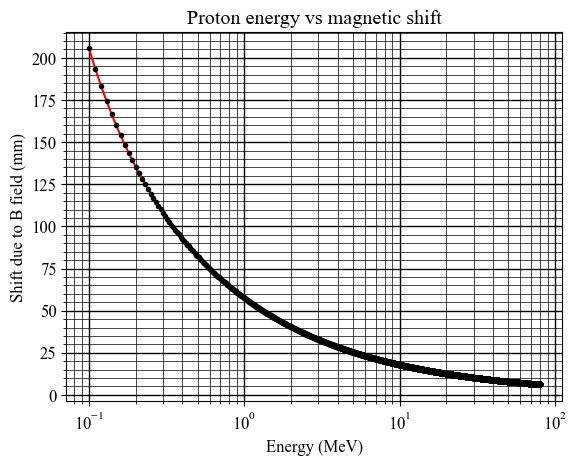

In [155]:
energy_chart = np.linspace(100,80000,8000)*keV_to_Joule
LB_chart = magnetic_shift(energy=energy_chart,DB=DB,lB=lB,m=mH,q=qp,B=B_field)

# Since LB is decreasing, reverse both arrays to make interpolation work
LB_to_E = interp1d(LB_chart[::-1], energy_chart[::-1], kind='cubic', fill_value='extrapolate')

given_LB = 13.256*mm  # energy in keV
E_result = LB_to_E(given_LB)/keV_to_Joule

print(f"For LB = {given_LB/mm} mm, E_proton = {E_result/1000 :.3f} MeV")

# plt.figure(figsize=(2,1))
plt.plot(energy_chart/keV_to_Joule/1e3,LB_chart/mm,"r-")
plt.plot(energy_chart/keV_to_Joule/1e3,LB_chart/mm,"ko",markersize=3)
plt.xlabel("Energy (MeV)")
plt.ylabel("Shift due to B field (mm)")
plt.xscale("log")
# plt.yscale("log")
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=1, color='k')
plt.grid(which='minor', linestyle='-', linewidth=0.5, color='k')
plt.title("Proton energy vs magnetic shift")
plt.show()

In [156]:
imagepath = r"D:\data Lab\ELI-NP March 2025\01_04_2025\separated out TP images\01042025_TP_19_31_scan_2-[Phosphor]_Shot1.tif"
image = io.imread(imagepath)
a = 12
b = image.shape[0]
c = 0
d = 649
image2 = image[a:b,c:d]
image = image[a:b,:]

# image = np.flip(image, axis=1)
# image = np.flip(image, axis=0)
image = np.flipud(image.T)
image2 = np.flipud(image2.T)
log_image_cutoff = 7

noise = np.mean(image[288:488,324:456])
pixel_to_mm = 0.025

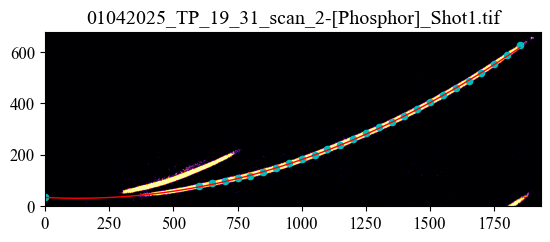

In [157]:
points = [[0, 0]]

for i in range(600,1900,50):
    max_x_index = find_index(image2[:,i],np.max(image2[:,i]))
    x0,y0 = max_x_index, i
    points.append([x0,y0])
    
# points.append([image.shape[0]-(276-c), 2058-a])

points = np.array(points)
# Fit a parabola (y = ax^2 + bx + c)
x = points[:, 1]
y = points[:, 0]
coeffs = np.polyfit(x, y, 2)  # Quadratic fit
coeffs[2] = 0

offset = 3
coeffs[2] += ((image.shape[0]-d)+offset)

y += ((image.shape[0]-d)+offset)
x_vals = np.linspace(min(x), max(x), 100)
y_vals = np.polyval(coeffs, x_vals)

plt.imshow(np.log(image)>log_image_cutoff,cmap="inferno",origin="lower")# ,extent=[x_min, x_max, y_min, y_max])
plt.plot(x_vals, y_vals, color='red', linewidth=1)  # Draw parabola
plt.scatter(x, y, color='c', s=20)  # Mark given points
plt.title(imagepath[-45:])
plt.show()

In [158]:
def get_magnetic_trace(image,coeffs,x_range=None, band=5):
    h, w = image.shape

    x_values = np.arange(0,w-50,1)
    y_values = np.polyval(coeffs, x_values).astype(int)
    valid_idx = (y_values >= band) & (y_values < h-band)
    x_values = x_values[valid_idx]
    y_values = y_values[valid_idx]

    mag_trace = np.zeros(shape=(2*band+1,len(x_values)))
    for i in range(len(x_values)):
        mag_trace[:,i] = image[y_values[i]-band:y_values[i]+band+1,i]

    plt.imshow(np.log(image)>7,cmap="inferno",origin="lower") # ,extent=[x_min, x_max, y_min, y_max])
    # plt.plot(x_values, y_values, color='red', linewidth=1)  # Draw parabola
    plt.fill_between(x=x_values,y1=y_values-band,y2=y_values+band,color="r",alpha=0.4)
    plt.title("selected band for proton trace")
    plt.show()

    return mag_trace

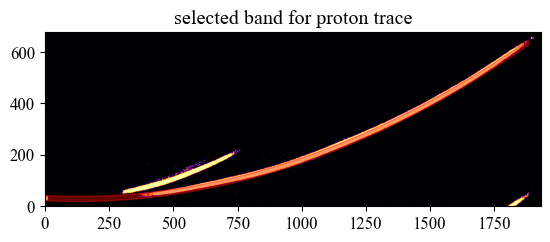

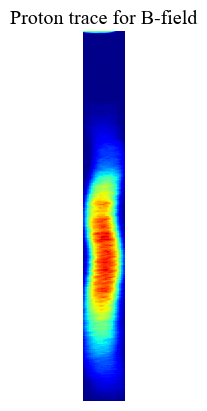

In [159]:
trace = get_magnetic_trace(image,coeffs,x_range=None,band=10)
trace = trace.T


plt.imshow(trace,cmap="jet",aspect=0.1)
plt.title("Proton trace for B-field")
plt.axis("off")
plt.show()